In [2]:
import astropy.coordinates as coord
import astropy.units as u
from astropy.table import Table, join, vstack
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import ascii

from scipy.interpolate import interp1d
from scipy.stats import binned_statistic

import gala.coordinates as gc
import gala.dynamics as gd
from gala.units import galactic
from pyia import GaiaData

In [6]:
g = GaiaData('/Users/adrian/data/APOGEE_DR15beta/allStar-t9-l31c-58158-with-gaiadr2.fits')
len(g)

397129

In [7]:
galcen = coord.Galactocentric(galcen_distance=8.1*u.kpc, z_sun=0*u.pc)

---

In [3]:
orp_rrl = Table.read('/Users/adrian/Downloads/gdr2_orphan_sergey.fits')

In [5]:
rrl_c = coord.SkyCoord(ra=orp_rrl['ra']*u.deg,
                       dec=orp_rrl['dec']*u.deg,
                       distance=orp_rrl['heldist']*u.kpc,
                       pm_ra_cosdec=orp_rrl['pmra'] * u.mas/u.yr,
                       pm_dec=orp_rrl['pmdec'] * u.mas/u.yr,
                       radial_velocity=0*u.km/u.s)

### Polygonal selections in each observable:

In [10]:
model_c = rrl_c.transform_to(gc.KoposovOrphan)
model_phi1 = model_c.phi1.wrap_at(180*u.deg)

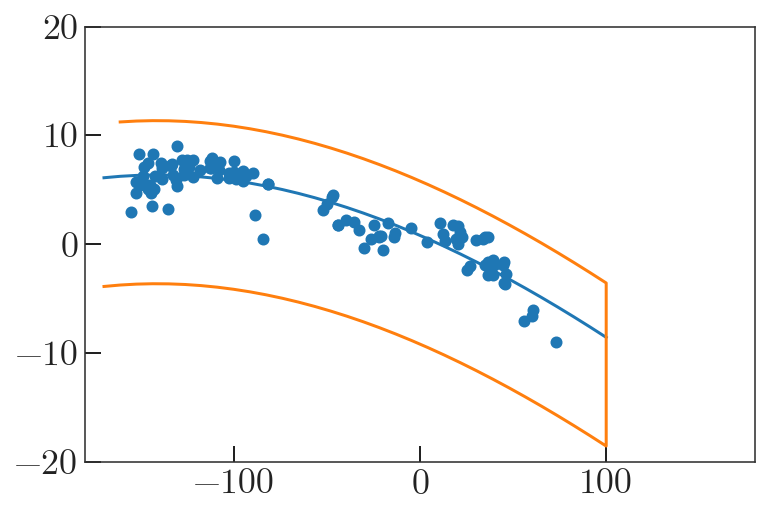

In [50]:
plt.scatter(model_c.phi1.wrap_at(180*u.deg).degree,
            model_c.phi2)

phi2_poly = np.poly1d(np.polyfit(model_c.phi1.wrap_at(180*u.deg).degree,
                                 model_c.phi2, deg=3))

_grid = np.linspace(-170, 100, 32)
plt.plot(_grid, phi2_poly(_grid), marker='')
plt.xlim(-180, 180)
plt.ylim(-20, 20)

_l = np.vstack((_grid, phi2_poly(_grid) - 10)).T
_r = np.vstack((_grid, phi2_poly(_grid) + 5)).T
phi12_poly = np.vstack((_l, _r[1:][::-1]))
plt.plot(phi12_poly[:, 0], phi12_poly[:, 1], marker='')

Text(0,0.5,'$\\mu_2$')

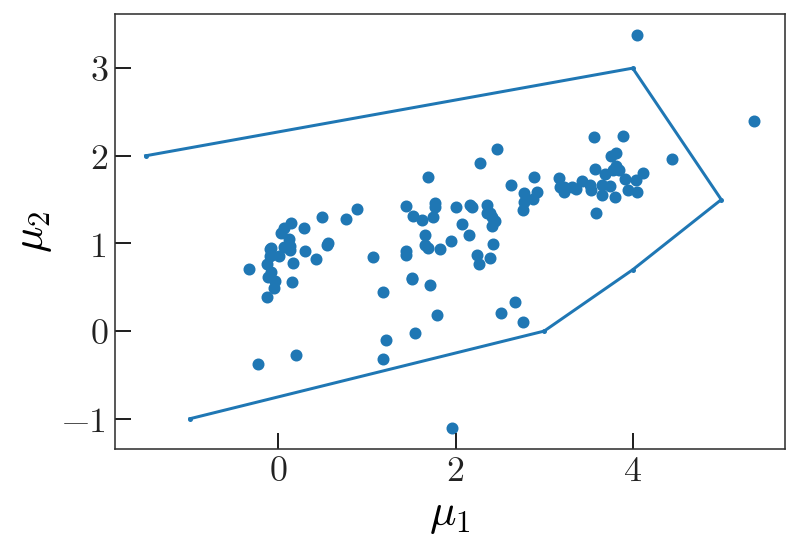

In [51]:
plt.scatter(model_c.pm_phi1_cosphi2, model_c.pm_phi2)

pm_poly = np.array([[-1.5, 2.],
                    [4, 3],
                    [5, 1.5],
                    [4, 0.7],
                    [3, 0],
                    [-1, -1]])

plt.plot(pm_poly[:, 0], pm_poly[:, 1])
plt.xlabel(r'$\mu_1$')
plt.ylabel(r'$\mu_2$')

---

# APOGEE

In [52]:
c = g.get_skycoord(distance=8*u.kpc, 
                   radial_velocity=np.array(g.VHELIO_AVG)*u.km/u.s)
stream_c = c.transform_to(gc.KoposovOrphan)

apogee_phi1 = stream_c.phi1.wrap_at(180*u.deg)
apogee_phi2 = stream_c.phi2

apogee_mask = ((apogee_phi1 > -100*u.deg) & (apogee_phi1 < 20*u.deg) &
               (apogee_phi2 > -10*u.deg) & (apogee_phi2 < 5*u.deg))

stream_c = stream_c[apogee_mask]

apogee_phi1 = stream_c.phi1.wrap_at(180*u.deg)
apogee_phi2 = stream_c.phi2

apogee_pm1 = stream_c.pm_phi1_cosphi2.to(u.mas/u.yr)
apogee_pm2 = stream_c.pm_phi2.to(u.mas/u.yr)

In [54]:
phi12_mask = mpl.patches.Path(phi12_poly).contains_points(np.vstack((apogee_phi1, apogee_phi2)).T)
pm_mask = mpl.patches.Path(pm_poly).contains_points(np.vstack((apogee_pm1, apogee_pm2)).T)
# rv_mask = mpl.patches.Path(rv_poly).contains_points(np.vstack((apogee_phi1, g.VHELIO_AVG[apogee_mask])).T)
rv_mask = np.ones(len(pm_mask), dtype=bool)
kin_mask = phi12_mask & pm_mask & rv_mask

In [55]:
phi12_mask.sum(), pm_mask.sum(), rv_mask.sum(), kin_mask.sum()

(5922, 255, 8053, 174)

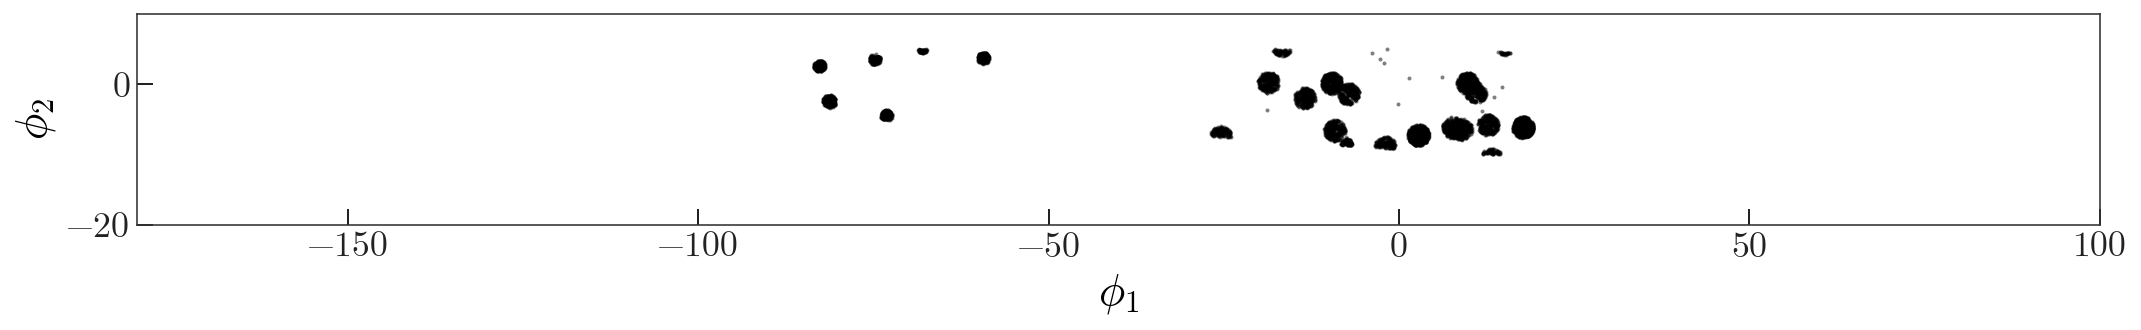

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))

ax.plot(apogee_phi1[phi12_mask], apogee_phi2[phi12_mask], 
        marker='o', color='k', ms=2,
        ls='none', alpha=0.5)

ax.set_xlim(-180, 100)
ax.set_ylim(-20, 10)
ax.set_aspect('equal')

ax.set_xlabel(r'$\phi_1$')
ax.set_ylabel(r'$\phi_2$')

fig.tight_layout()

In [57]:
feh_mask = (g.M_H[apogee_mask] < -1) & (g.M_H[apogee_mask] > -2.5)
gd1_full_mask = kin_mask & feh_mask
gd1_full_mask.sum()

46

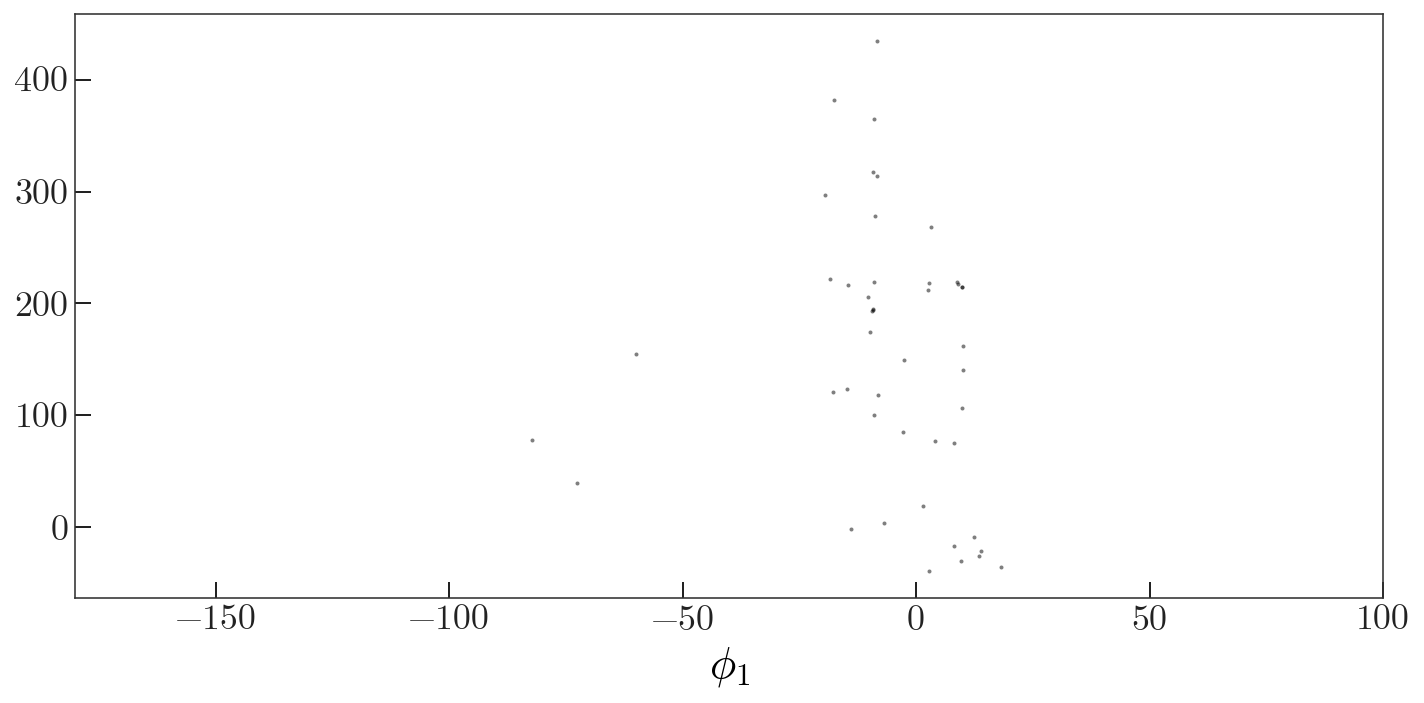

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(apogee_phi1[gd1_full_mask], 
        g.VHELIO_AVG[apogee_mask][gd1_full_mask], 
        marker='o', color='k', ms=2,
        ls='none', alpha=0.5)

ax.set_xlim(-180, 100)
# ax.set_ylim(-20, 10)
# ax.set_aspect('equal')

ax.set_xlabel(r'$\phi_1$')
# ax.set_ylabel(r'$\phi_2$')

fig.tight_layout()

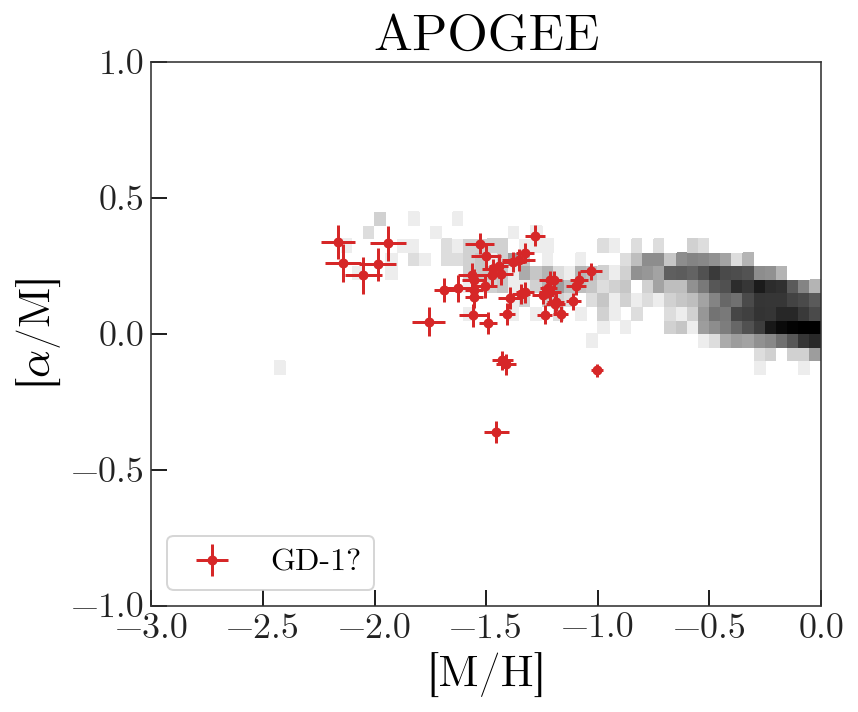

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

ax.errorbar(g.M_H[apogee_mask][gd1_full_mask], 
            g.ALPHA_M[apogee_mask][gd1_full_mask],
            xerr=g.M_H_ERR[apogee_mask][gd1_full_mask], 
            yerr=g.ALPHA_M_ERR[apogee_mask][gd1_full_mask], 
            marker='o', ls='none', color='tab:red', 
            label='GD-1?', zorder=100)

H, xe, ye = np.histogram2d(g.M_H[apogee_mask][phi12_mask],
                           g.ALPHA_M[apogee_mask][phi12_mask],
                           bins=(np.arange(-3, 0+1e-3, 0.05),
                                 np.arange(-1, 1+1e-3, 0.05)))
ax.pcolormesh(xe, ye, H.T, cmap='Greys', zorder=-100, 
              norm=mpl.colors.LogNorm())

ax.set_xlim(-3, 0)
ax.set_ylim(-1, 1)

ax.legend(loc='lower left', fontsize=16)

ax.set_xlabel('[M/H]')
ax.set_ylabel(r'[$\alpha$/M]')

ax.set_title('APOGEE')
fig.set_facecolor('w')